<a href="https://colab.research.google.com/github/lino62U/ADA/blob/main/fitness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

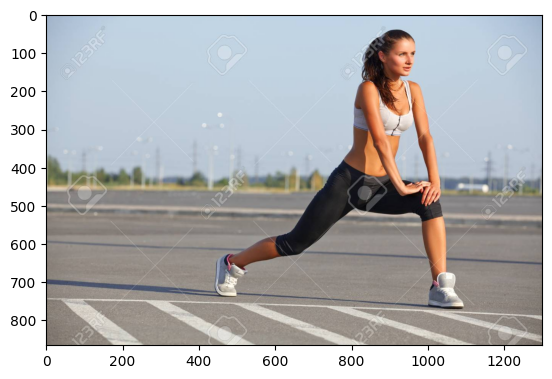

In [ ]:
import cv2
import numpy as np

# Cargar la imagen
image = cv2.imread('fit1.jpg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar suavizado para reducir el ruido
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detección de bordes con el algoritmo Canny
edges = cv2.Canny(blurred, 30, 150)  # Ajustar los valores de umbral según sea necesario

# Crear una máscara para limitar la detección de bordes a la región de interés
mask = np.zeros_like(edges)
height, width = image.shape[:2]
roi_corners = np.array([[(0, height), (width // 2, height // 2), (width, height)]], dtype=np.int32)
cv2.fillPoly(mask, roi_corners, 255)
edges = cv2.bitwise_and(edges, mask)

# Encontrar contornos en la imagen de bordes
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos por área mínima
min_area = 1000
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# Dibujar contornos en la imagen original
cv2.drawContours(image, filtered_contours, -1, (0, 255, 0), 2)

# Mostrar la imagen con los contornos detectados
# cv2.imshow('Contours', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Guardar la imagen
cv2.imwrite('fit2_contours.jpg', image)

# Mostrar con matplotlib
import matplotlib.pyplot as plt
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()


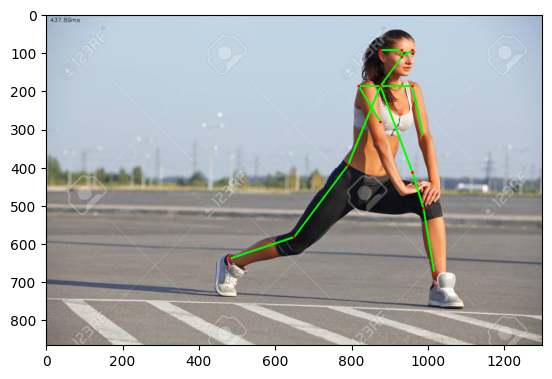

In [ ]:
import cv2 as cv

import matplotlib.pyplot as plt

# Load the model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

inWidth = 368
inHeight = 368
thr = 0.2

BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

def pose_estimation(frame):
    frame_width = frame.shape[1]
    frame_height = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heat_map = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heat_map)
        x = (frame_width * point[0]) / out.shape[3]
        y = (frame_height * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        part_from = pair[0]
        part_to = pair[1]
        assert(part_from in BODY_PARTS)
        assert(part_to in BODY_PARTS)

        id_from = BODY_PARTS[part_from]
        id_to = BODY_PARTS[part_to]

        if points[id_from] and points[id_to]:
            cv.line(frame, points[id_from], points[id_to], (0, 255, 0), 3)
            cv.ellipse(frame, points[id_from], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[id_to], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)


    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame


img = cv.imread("fit3.jpg")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

estimated_image = pose_estimation(img)
estimated_image_rgb = cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB)

plt.imshow(estimated_image_rgb)
plt.show()